In [1]:
import sys
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import numpy as np
import gc
sns.set()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
sys.path.insert(0, '../')
from utils.utils import load_n_samples, AEDatagenerator


# Some major settings

In [3]:
use_dropout = False
training = False
noisy = True

In [4]:
additional = ''
if use_dropout:
    additional+='dropout'
if noisy:
    additional+='_noisy'
if not additional:
    name_dec = '../models/dec.h5'
    name_enc = '../models/enc.h5'
else:
    name_dec = '../models/dec_{0}.h5'.format(additional)
    name_enc = '../models/enc_{0}.h5'.format(additional)


# Loading data

In [5]:
abs_path = '../data/cropped/'
files = os.listdir(abs_path)
files = list(map(lambda x: os.path.join(abs_path, x), files))

In [6]:
train_path, test_path = train_test_split(files,test_size=0.15)

In [7]:
len(train_path), len(test_path)

(54032, 9536)

In [8]:
data = load_n_samples(abs_path=abs_path,samples=1000,workers=2)

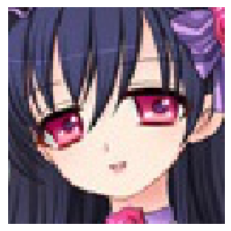

In [9]:
plt.imshow(data[0])
plt.xticks([])
plt.yticks([]);

# Training AE

In [10]:
def create_encoder(input_shape,code_size, use_dropout=True):
        encoder = tf.keras.models.Sequential(name='encoder')
        encoder.add(L.InputLayer(input_shape))
        if use_dropout:
            encoder.add(L.Dropout(0.3))
        encoder.add(L.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Flatten())
        encoder.add(L.Dense(units=code_size,activation='elu'))
        return encoder 
    
def create_decoder(code_size):
        decoder = tf.keras.models.Sequential(name='decoder')
        decoder.add(L.InputLayer((code_size,)))
        decoder.add(L.Dense(2*2*512,activation='elu'))
        decoder.add(L.Reshape(target_shape=(2,2,512)))
        decoder.add(L.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
        return decoder
    
def build_model(input_shape,code_size, use_dropout=True,
               print_summary=True,encoder_weights=None,
               decoder_weights=None):
    K.clear_session()
    encoder = create_encoder(input_shape,code_size,use_dropout)
    if encoder_weights:
        encoder.load_weights(encoder_weights)
    decoder = create_decoder(code_size)
    if decoder_weights:
        decoder.load_weights(decoder_weights)
    inp = L.Input(original_dim)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
    autoencoder.compile(optimizer="adamax", loss='mse')
    if print_summary:
        print(autoencoder.summary())
    return autoencoder,encoder,decoder

In [11]:
batch_size = 128
original_dim = (128,128,3)
code_size = 16
epochs = 10

In [12]:
if training:
    train_gen = AEDatagenerator(pathes=train_path,batch_size=batch_size,
                            dim=original_dim[:2],
                            n_channels=original_dim[2],with_noise=noisy,std=1)
    test_gen = AEDatagenerator(pathes=test_path,batch_size=batch_size,
                            dim=original_dim[:2],
                            n_channels=original_dim[2],with_noise=noisy,std=1)
    autoencoder,encoder,decoder = build_model(original_dim,code_size=code_size, use_dropout=use_dropout)
    hist = autoencoder.fit_generator(generator=train_gen,validation_data=test_gen,epochs=epochs)
    if not os.path.exists('../models'):
        os.mkdir('../models')
    encoder.save_weights(name_enc)
    decoder.save_weights(name_dec)
else:
    autoencoder,encoder,decoder = build_model(original_dim,code_size=code_size, use_dropout=use_dropout,
                             decoder_weights=name_dec, encoder_weights=name_enc)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 16)                650576    
_________________________________________________________________
decoder (Sequential)         (None, 128, 128, 3)       3962691   
Total params: 4,613,267
Trainable params: 4,613,267
Non-trainable params: 0
_________________________________________________________________
None


# Having fun :)

## Reconstructing images and image morphing (denoising)

In [13]:
def add_noise(X, sigma=0.1):
        noise = np.random.normal(0, sigma, X.shape)
        return X + noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


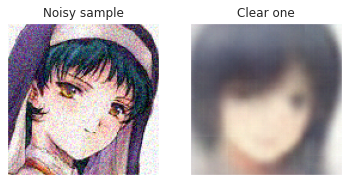

In [14]:
if noisy:
    idx = np.random.choice(data.shape[0])
    noisy_X = add_noise(data[idx])
    prediction = np.clip(autoencoder.predict(np.expand_dims(noisy_X,axis=0))[0],0,1)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax1.imshow(noisy_X)
    ax1.set_title('Noisy sample')
    ax2.imshow(prediction)
    ax2.set_title('Clear one');

1/1 [==============================] - 0s 491ms/sample - loss: 0.0195
Loss : 0.019523171707987785


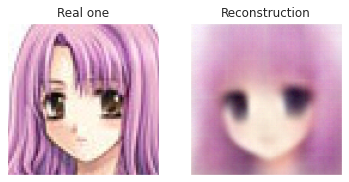

In [15]:
idx = np.random.choice(data.shape[0])
prediction = np.clip(autoencoder.predict(np.expand_dims(data[idx],axis=0))[0],0,1)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.imshow(data[idx])
ax1.set_title('Real one')
ax2.imshow(prediction)
ax2.set_title('Reconstruction');
print('Loss : {0}'.format(autoencoder.evaluate(np.expand_dims(data[idx],axis=0),np.expand_dims(data[idx],axis=0))))

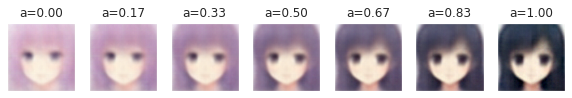

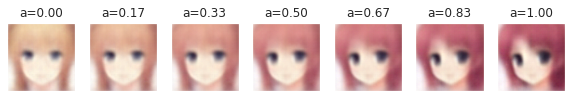

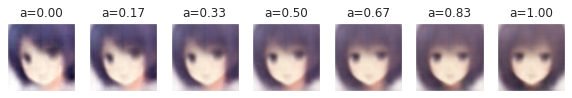

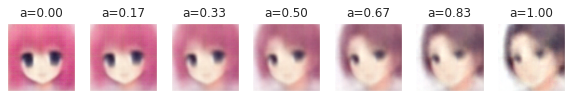

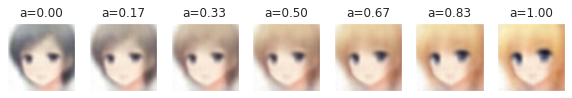

In [16]:
for _ in range(5):
    image1,image2 = data[np.random.randint(0,len(data),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))
    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.clip(output_image,0,1))
        plt.title("a=%.2f"%a)
        
    plt.show()

## Searching for relevant images

In [17]:
codes = encoder.predict(data)

In [18]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

/home/volodymyr/envs/autoenc_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


NearestNeighbors(metric='euclidean')

In [19]:
def get_similar(image, n_neighbors=5):
    code = encoder.predict(image[None])
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    return distances,data[idx]

def show_similar(image):
    distances,neighbors = get_similar(image,n_neighbors=4)
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title("Original image")
    for i in range(4):
        if distances[i]!=0:
            plt.subplot(1,5,i+2)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(neighbors[i])
            plt.title("Dist=%.3f"%distances[i])
    plt.show()

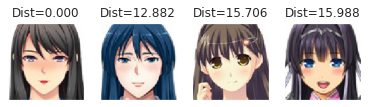

In [20]:
show_similar(data[99])

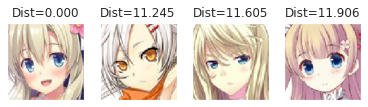

In [21]:
show_similar(data[53])

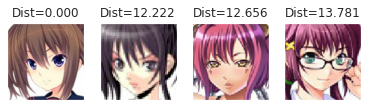

In [22]:
show_similar(data[10])

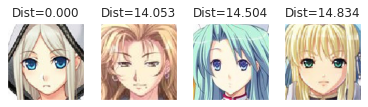

In [23]:
show_similar(data[513])

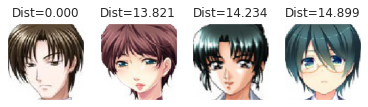

In [24]:
show_similar(data[721])

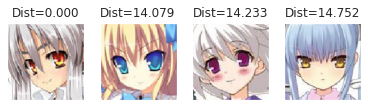

In [25]:
show_similar(data[30])

## Visualize layers of encoder

In [26]:
model = tf.keras.Model(inputs=encoder.inputs, outputs=encoder.layers[-4].output)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0   

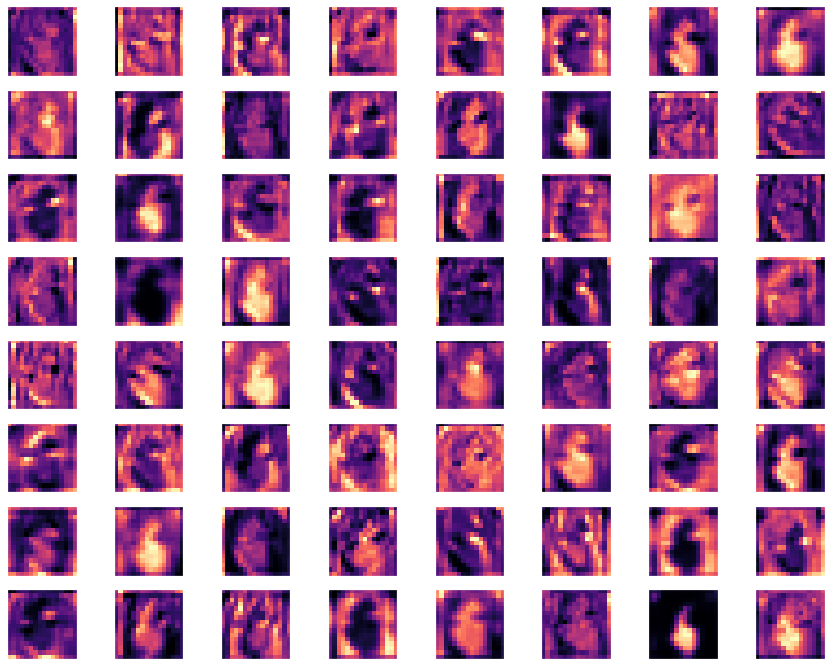

In [28]:
img = data[np.random.choice(data.shape[0])]
feature_maps = model.predict(np.expand_dims(img,axis=0))
square = 8
ix = 1
plt.figure(figsize=(15,12))
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='magma')
        ix += 1
plt.show()